In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [20]:
def normalize_data(data):
    return np.round((data - np.min(data)) / (np.max(data) - np.min(data)), 3)

## Create Paired Distributions For Scatter Plot

In [21]:
def create_dist(n, m1, s1, m2, s2, perc):
    np.random.seed(36)
    """Function to create binary outcomes from two different normal distributions."""
    # each class from a slightly diff normal dist
    class1 = [i for i in np.random.normal(m1, s1, int(n * perc))]
    class0 = [i for i in np.random.normal(m2, s2, int(n) - int(n * perc))]

    # coerce data to list
    x = class1 + class0

    # coerce to [0, 1]
    x = normalize_data(x)

    # create labels
    y = [1] * int(n * perc) + [0] * (int(n) - int(n * perc))
    y_pos = [i for i in np.random.normal(0, 0.15, int(n))]

    # send data to df
    out_df = pd.DataFrame(list(zip(x, y_pos, y)), columns=["xPos", "yPos", "label"])
    return x, y, out_df

In [24]:
n1 = 50
n2 = 25

n = n1 + n2

x_group1, y_group1, df_group1 = create_dist(n1, 0.65, 0.1, 0.4, 0.15, 0.6)
x_group2, y_group2, df_group2 = create_dist(n2, 0.55, 0.15, 0.3, 0.1, 0.4)

<AxesSubplot:xlabel='xPos', ylabel='yPos'>

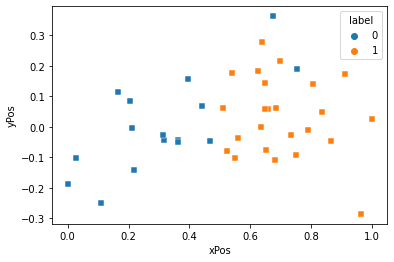

In [25]:
# view data
sns.scatterplot(data=df_group1, x="xPos", y="yPos", hue="label", marker="s")

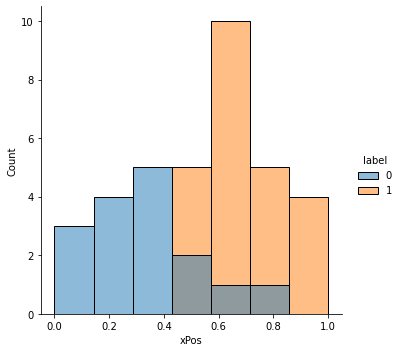

In [29]:
sns.displot(df_group1, x="xPos", hue="label")

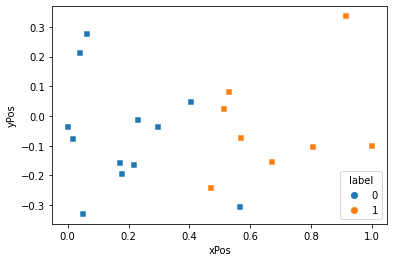

In [27]:
# view data
sns.scatterplot(data=df_group2, x="xPos", y="yPos", hue="label", marker="s")
plt.show()

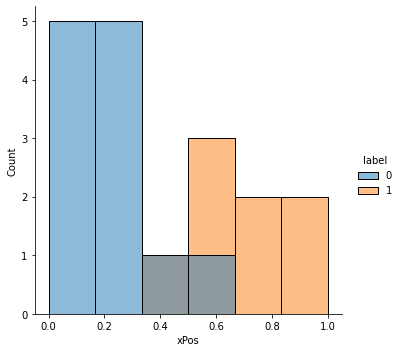

In [30]:
sns.displot(df_group2, x="xPos", hue="label")

## Generate Classification Eval Metrics For Dataset

In [31]:
# utility funcs; move classification threshold & calculate metrics
def a_simple_classifier(x, thres=0.5):
    predicted = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] > thres:
            predicted[i] = 1
    return predicted


def calculate_metrics(predicted, actual):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predicted)):
        if (predicted[i] == 1) & (actual[i] == 1):
            TP += 1
        elif (predicted[i] == 1) & (actual[i] == 0):
            FP += 1
        elif (predicted[i] == 0) & (actual[i] == 0):
            TN += 1
        else:
            FN += 1

    accuracy = (TP + TN) / (TP + FP + TN + FN + 0.00000001)
    precision = (TP) / (TP + FP + 0.00000001)
    recall = (TP) / (TP + FN + 0.00000001)
    f1_score = (2 * precision * recall) / (precision + recall + 0.00000001)
    fpr = 1.0 * FP / (FP + TN + 0.000000001)
    tpr = recall

    return accuracy, precision, recall, f1_score, fpr, tpr

In [32]:
# init arrays
thresh = np.arange(0, 1, 0.025)
accuracy = np.zeros(len(thresh))
precision = np.zeros(len(thresh))
recall = np.zeros(len(thresh))
f1_score = np.zeros(len(thresh))
fpr = np.zeros(len(thresh))
tpr = np.zeros(len(thresh))

print("Threshold \t Accuracy \t Precision\t Recall \t  F1 Score \t FPR \t TPR ")


def calculate_plot_metrics(x, y, verbose=False):
    out_dict = {}
    # loop and calculate values
    for i in range(len(thresh)):
        prediction = a_simple_classifier(x, thresh[i])
        (
            accuracy[i],
            precision[i],
            recall[i],
            f1_score[i],
            fpr[i],
            tpr[i],
        ) = calculate_metrics(prediction, y)
        if verbose == True:
            print(
                f"{thresh[i]: .2f}\t\t {accuracy[i]: .2f}\t\t {precision[i]: .2f}\t\t {recall[i]: .2f}\t\t {f1_score[i]: .2f}\t\t {fpr[i]: .2f}\t\t {tpr[i]: .2f}"
            )

    # plot metric tradeoff
    plt.plot(thresh, accuracy, "r")
    plt.plot(thresh, precision, "g")
    plt.plot(thresh, recall, "b")
    plt.plot(thresh, f1_score, "k")

    plt.legend(["Accuracy", "Precision", "Recall", "F1 Score"])
    plt.xlabel("Threshold")
    plt.ylabel("Scores")
    plt.title("Change of Evaluation Metrics according to Threshold")

    plt.show()

    df_out = pd.DataFrame(
        list(zip(thresh, accuracy, precision, recall, f1_score, fpr, tpr)),
        columns=[
            "threshold",
            "accuracy",
            "precision",
            "recall",
            "f1_score",
            "fpr",
            "tpr",
        ],
    )
    return df_out

Threshold 	 Accuracy 	 Precision	 Recall 	  F1 Score 	 FPR 	 TPR 


## Plot Classification Eval Tradeoff

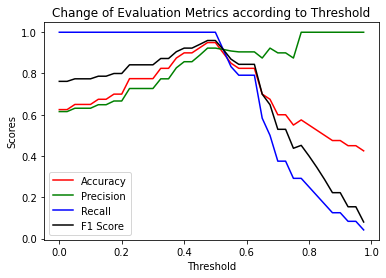

In [33]:
metrics_group1 = calculate_plot_metrics(x_group1, y_group1, False)

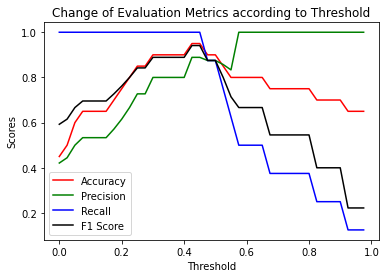

In [34]:
metrics_group2 = calculate_plot_metrics(x_group2, y_group2, False)

## Plot ROC

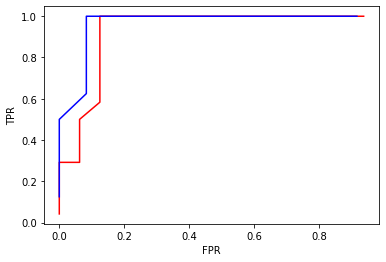

In [35]:
# plot roc
plt.plot(metrics_group1["fpr"], metrics_group1["tpr"], "r")
plt.plot(metrics_group2["fpr"], metrics_group2["tpr"], "b")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## Export data for article
- ROC Points (fpr, tpr, metrics)
- ScatterPlot

In [36]:
df_group1["group"] = "circle"
df_group2["group"] = "square"

df = pd.concat([df_group1, df_group2])

In [37]:
df.to_json("scatterData.json", orient="records")

In [38]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(df['label'], a_simple_classifier(df['xPos'].values)).ravel()

tn

25

In [39]:
metrics_group1["group"] = "circle"
metrics_group2["group"] = "square"

roc_df = pd.concat(
    [
        metrics_group1[["threshold", "fpr", "tpr", "group"]],
        metrics_group2[["threshold", "fpr", "tpr", "group"]],
    ]
)

In [40]:
roc_df.to_json("rocData.json", orient="records")